%%time
<h1>Introduction</h1>

Sweet Lift Taxi would like to maximize the number of tax orders during peak hours. To that end, this project looks at models to predict the number of taxi orders in the next hour and selects the most optimized and accurate model to help Sweet Lift do just that.

Importing the necessary libraries

In [1]:
%%time
import pandas as pd
import numpy as np
from IPython.display import display
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression	
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')


CPU times: user 2.33 s, sys: 414 ms, total: 2.74 s
Wall time: 3.15 s


Importing the data

In [2]:
%%time
taxi_data = pd.read_csv("/Users/admin/Desktop/GitHub/new_repos/sweet-lift-taxi/taxi.csv", encoding = "utf-8", parse_dates=[0])


CPU times: user 29.5 ms, sys: 5.46 ms, total: 34.9 ms
Wall time: 34.2 ms


Viewing a sample of the data and info about the dataframe

In [3]:
%%time
display(taxi_data.sample(10))
taxi_data.info()

,datetime,num_orders
9352,2018-05-04 22:40:00,13
25644,2018-08-26 02:00:00,33
23924,2018-08-14 03:20:00,55
891,2018-03-07 04:30:00,4
8017,2018-04-25 16:10:00,21
26447,2018-08-31 15:50:00,31
3154,2018-03-22 21:40:00,7
22621,2018-08-05 02:10:00,23
25401,2018-08-24 09:30:00,25
22142,2018-08-01 18:20:00,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
CPU times: user 14.3 ms, sys: 3.03 ms, total: 17.4 ms
Wall time: 16.2 ms


<h2>Data Preprocessing</h2>

This code looks for duplicate columns. Since there are only two columns, both with no null values, the preprocessing is fairly limited.

In [4]:
%%time
print(taxi_data.duplicated().sum())

0
CPU times: user 2.72 ms, sys: 1.38 ms, total: 4.1 ms
Wall time: 2.64 ms


In [5]:
%%time
taxi_data = taxi_data.set_index('datetime')
taxi_data.sort_index(inplace=True)

CPU times: user 1.26 ms, sys: 510 µs, total: 1.77 ms
Wall time: 1.32 ms


<h2>Data Resampling</h2>

This code resamples the data by one hour.

In [6]:
%%time
taxi_data = taxi_data.resample('1H').sum()
display(taxi_data.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


CPU times: user 8.57 ms, sys: 2.41 ms, total: 11 ms
Wall time: 10.2 ms


<h2>EDA</h2>

This code looks at a pairplot of the columns. It is a histogram skewed to the right.

CPU times: user 75.2 ms, sys: 5.97 ms, total: 81.2 ms
Wall time: 84.4 ms


<Axes: xlabel='datetime'>

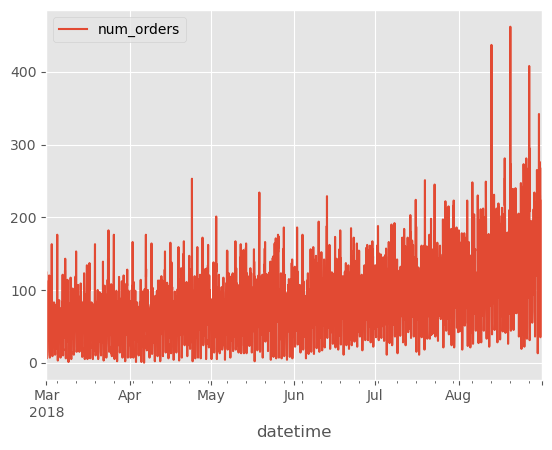

In [7]:
%%time
taxi_data.plot()


CPU times: user 58.3 ms, sys: 3.71 ms, total: 62 ms
Wall time: 63.4 ms


<Axes: xlabel='datetime'>

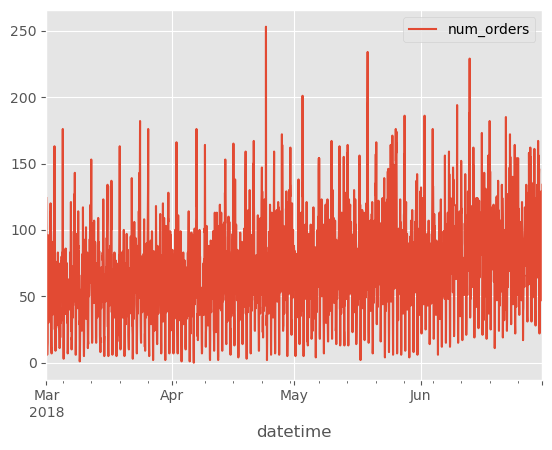

In [8]:
%%time
taxi_data['2018-01':'2018-06'].plot()

CPU times: user 75.1 ms, sys: 5.09 ms, total: 80.2 ms
Wall time: 76.8 ms


<Axes: xlabel='datetime'>

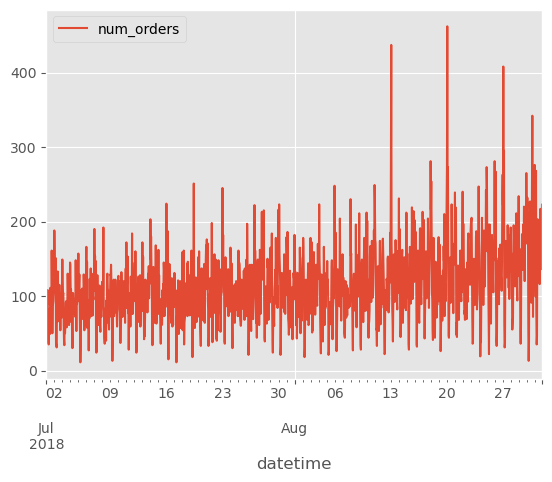

In [9]:
%%time
taxi_data['2018-07':'2018-12'].plot()

CPU times: user 46 ms, sys: 2.66 ms, total: 48.6 ms
Wall time: 46.7 ms


<Axes: xlabel='datetime'>

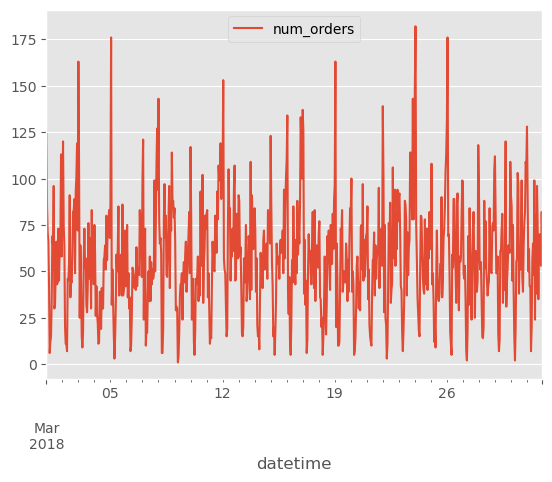

In [10]:
%%time
taxi_data['2018-01':'2018-03'].plot()

CPU times: user 102 ms, sys: 6.77 ms, total: 109 ms
Wall time: 104 ms


<Axes: xlabel='datetime'>

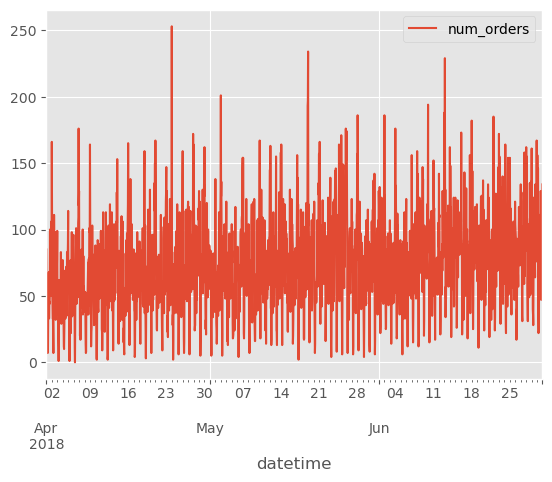

In [11]:
%%time
taxi_data['2018-04':'2018-06'].plot()

CPU times: user 69.7 ms, sys: 2.54 ms, total: 72.2 ms
Wall time: 70.8 ms


<Axes: xlabel='datetime'>

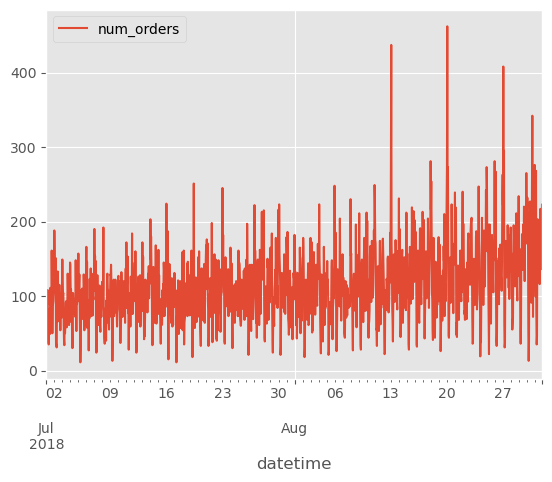

In [12]:
%%time
taxi_data['2018-07':'2018-09'].plot()

<h2>Machine Learning Models</h2>

This function creates features based on the datetime information for the forecast horizon

In [13]:
%%time
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    
    return data

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


In [14]:
%%time
make_features(taxi_data, 10, 10)


CPU times: user 6.26 ms, sys: 1.11 ms, total: 7.37 ms
Wall time: 6.29 ms


,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,173.3
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,166.6
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,162.9


This code drops the null values created by making the features.

In [15]:
%%time
taxi_data = taxi_data.dropna()

CPU times: user 2.91 ms, sys: 1.38 ms, total: 4.3 ms
Wall time: 3.3 ms


This code creates the categorical features and then encodes them, first using label encoding, then OHE for the XGBoost model.

In [16]:
%%time
categorical_features = ['month', 'day', 'dayofweek', 'hour']

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [17]:
%%time
taxi_data_encoded = pd.get_dummies(taxi_data, columns=categorical_features)

CPU times: user 6.87 ms, sys: 1.94 ms, total: 8.81 ms
Wall time: 7.51 ms


In [18]:
%%time
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    taxi_data[col] = le.fit_transform(taxi_data[col])
    label_encoders[col] = le

CPU times: user 2.93 ms, sys: 1.33 ms, total: 4.26 ms
Wall time: 3.09 ms


<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

This code splits the data into train, test, and validation sets.

In [19]:
X = taxi_data.drop(['num_orders'], axis=1)
y=taxi_data['num_orders']

X_train1, X_test, y_train1, y_test = train_test_split (X, y, test_size=0.10, random_state=54321, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train1, y_train1, test_size=0.11, random_state=54321, shuffle=False)

In [20]:
X_encoded = taxi_data_encoded.drop(['num_orders'], axis=1)
y_encoded=taxi_data_encoded['num_orders']

X_encoded_train1, X_encoded_test, y_encoded_train1, y_encoded_test = train_test_split (X_encoded, y_encoded, test_size=0.10, random_state=54321, shuffle=False)
X_encoded_train, X_encoded_valid, y_encoded_train, y_encoded_valid = train_test_split(X_encoded_train1, y_encoded_train1, test_size=0.11, random_state=54321, shuffle=False)

This code creates a list of numeric features, then scales them.

In [21]:
numeric = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'rolling_mean']

In [22]:
%%time
def scaling(features_train, features_test, features_valid):
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    return features_train, features_test, features_valid

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [23]:
%%time
scaling(X_train, X_test, X_valid)

CPU times: user 11 ms, sys: 1.57 ms, total: 12.6 ms
Wall time: 11.5 ms


(                     month  day  dayofweek  hour     lag_1     lag_2  \
 datetime                                                               
 2018-03-01 10:00:00      0    0          3    10 -0.150228 -1.130114   
 2018-03-01 11:00:00      0    0          3    11 -0.290293 -0.149836   
 2018-03-01 12:00:00      0    0          3    12  0.606121 -0.289876   
 2018-03-01 13:00:00      0    0          3    13 -1.242731  0.606378   
 2018-03-01 14:00:00      0    0          3    14 -1.186706 -1.242146   
 ...                    ...  ...        ...   ...       ...       ...   
 2018-07-26 05:00:00      4   25          3     5  1.586572  1.866735   
 2018-07-26 06:00:00      4   25          3     6  0.241953  1.586656   
 2018-07-26 07:00:00      4   25          3     7 -1.494848  0.242275   
 2018-07-26 08:00:00      4   25          3     8 -0.990615 -1.494217   
 2018-07-26 09:00:00      4   25          3     9  0.157914 -0.990074   
 
                         lag_3     lag_4     lag_

In [24]:
%%time
scaling(X_encoded_train, X_encoded_test, X_encoded_valid)

CPU times: user 11.7 ms, sys: 1.5 ms, total: 13.2 ms
Wall time: 14.5 ms


(                        lag_1     lag_2     lag_3     lag_4     lag_5  \
 datetime                                                                
 2018-03-01 10:00:00 -0.150228 -1.130114 -1.661654 -1.745384 -1.911783   
 2018-03-01 11:00:00 -0.290293 -0.149836 -1.129638 -1.661391 -1.743883   
 2018-03-01 12:00:00  0.606121 -0.289876 -0.149608 -1.129436 -1.659933   
 2018-03-01 13:00:00 -1.242731  0.606378 -0.289612 -0.149519 -1.128249   
 2018-03-01 14:00:00 -1.186706 -1.242146  0.606415 -0.289507 -0.148832   
 ...                       ...       ...       ...       ...       ...   
 2018-07-26 05:00:00  1.586572  1.866735  3.434503 -0.037529  2.089836   
 2018-07-26 06:00:00  0.241953  1.586656  1.866454  3.434177 -0.036899   
 2018-07-26 07:00:00 -1.494848  0.242275  1.586446  1.866310  3.433036   
 2018-07-26 08:00:00 -0.990615 -1.494217  0.242404  1.586334  1.865969   
 2018-07-26 09:00:00  0.157914 -0.990074 -1.493649  0.242448  1.586135   
 
                         lag_6     l

This function calculates the RMSE to be used in all the models.

In [25]:
%%time
def rmse(y_true, y_pred):
    return(mean_squared_error(y_true, y_pred, squared=False))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


This function creates a dummy model for comparison to the rest of the models.

In [26]:
%%time
def dummy(features_train, target_train, features_valid, target_valid):
    dummy_regress = DummyRegressor(strategy='mean')
    dummy_regress.fit(features_train, target_train)
    predict_score = dummy_regress.predict(features_valid)
    dummy_score = rmse(predict_score, target_valid)
    print(dummy_score)
    return

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


In [27]:
%%time
dummy(X_train, y_train, X_valid, y_valid)

58.31056137667172
CPU times: user 1.18 ms, sys: 528 µs, total: 1.71 ms
Wall time: 1.28 ms


In [28]:
%%time
dummy(X_encoded_train, y_encoded_train, X_encoded_valid, y_encoded_valid)

58.31056137667172
CPU times: user 1.24 ms, sys: 460 µs, total: 1.7 ms
Wall time: 1.37 ms


These are the functions to train the six different models: three gradient models and three non-gradient models.

In [29]:
%%time
def train_decision_model(features_train, target_train, features_valid, target_valid, a, b):

    best_decision_rmse = 0
    best_depth = 0

    for depth in range(a,b):
        decision_model = DecisionTreeRegressor(random_state=54321, max_depth=depth)
        decision_model.fit(features_train, target_train)
        predictions = decision_model.predict(features_valid)
        decision_score = rmse(target_valid, predictions)
        print('The RMSE for', depth, 'is', decision_score) 
          
        if best_decision_rmse == 0:
            best_decision_rmse = decision_score
            best_depth = depth
        if decision_score < best_decision_rmse:
            best_decision_rmse = decision_score
            best_depth = depth
                            
    final_decision_model = DecisionTreeRegressor(random_state=54321, max_depth=best_depth)
    final_decision_model.fit(features_train, target_train)
    final_predictions = final_decision_model.predict(features_valid)
    final_decision_score = rmse(target_valid, final_predictions)
    print('The final RMSE for', best_depth, 'is', final_decision_score) 
    
    return final_decision_score


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.15 µs


In [30]:
%%time
def train_random_model(features_train, target_train, features_valid, target_valid, a, b):

    best_random_rmse = 0
    best_est = 0

    for est in range(a,b):
        random_model = RandomForestRegressor(random_state=54321, n_estimators=est)
        random_model.fit(features_train, target_train)
        predictions = random_model.predict(features_valid)
        random_score = rmse(target_valid, predictions)
        print('The RMSE for', est, 'is', random_score) 
  
        if best_random_rmse == 0:
            best_random_rmse = random_score
            best_est = est
        if random_score < best_random_rmse:
            best_random_rmse = random_score
            best_est = est
            

    final_random_model = RandomForestRegressor(random_state=54321, n_estimators=best_est)
    final_random_model.fit(features_train, target_train)
    final_predictions = final_random_model.predict(features_valid)
    final_random_score = rmse(target_valid, final_predictions)
    print('The final RMSE for', best_est, 'is', final_random_score) 
    print(final_random_score)

    return final_random_score

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [31]:
%%time
def train_linear_model(features_train, target_train, features_valid, target_valid):
    linear_model = LinearRegression()
    linear_model.fit(features_train, target_train)
    predictions = linear_model.predict(features_valid)
    linear_score = rmse(target_valid, predictions)
    print('The RMSE for the linear model is', linear_score) 
    return linear_score

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [32]:
%%time
def lgbm(features_train, target_train, features_valid, target_valid, a, b):

    best_lgbm_rmse = 0
    best_est = 0

    for est in range(a,b):
        lgbm_model = LGBMRegressor(num_leaves=30, max_depth=20, n_estimators=est, random_state=54321)
        lgbm_model.fit(features_train, target_train)
        predictions = lgbm_model.predict(features_valid)
        lgbm_score = rmse(target_valid, predictions)
        print('The RMSE for', est, 'is', lgbm_score) 
  
        if best_lgbm_rmse == 0:
            best_lgbm_rmse = lgbm_score
            best_est = est
        if lgbm_score < best_lgbm_rmse:
            best_lgbm_rmse = lgbm_score
            best_est = est
            

    final_lgbm_model = LGBMRegressor(num_leaves=30, max_depth=20, n_estimators=best_est, random_state=54321)
    final_lgbm_model.fit(features_train, target_train)
    final_predictions = final_lgbm_model.predict(features_valid)
    final_lgbm_score = rmse(target_valid, final_predictions)
    print('The final RMSE for', best_est, 'is', final_lgbm_score) 
    return final_lgbm_score

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [33]:
%%time
def cat(features_train, target_train, features_valid, target_valid, a, b):

    best_cat_rmse = 0
    best_its = 0

    for its in range(a,b):
        cat_model = CatBoostRegressor(loss_function="RMSE", iterations=its, random_seed=54321)
        cat_model.fit(features_train, target_train, cat_features=categorical_features, verbose=10)

        cat_predictions = cat_model.predict(features_valid)
        cat_rmse = rmse(target_valid, cat_predictions)
        print('The RMSE for', its, 'is', cat_rmse) 
  
        if best_cat_rmse == 0:
            best_cat_rmse = cat_rmse
            best_its = its
        if cat_rmse < best_cat_rmse:
            best_cat_rmse = cat_rmse
            best_its = its
            

    final_cat_model = CatBoostRegressor(loss_function='RMSE', iterations=best_its, random_seed=54321)
    final_cat_model.fit(features_train, target_train, cat_features=categorical_features, verbose=10)
    final_cat_predictions = final_cat_model.predict(features_valid)
    final_cat_score = rmse(target_valid, final_cat_predictions)
    print('The final RMSE for', best_its, 'is', final_cat_score) 
    return final_cat_score

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.91 µs


In [34]:
%%time
def xgb(features_train, target_train, features_test, target_test, a, b):

    best_xgb_rmse = 0
    best_est = 0

    for est in range(a,b):
        xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=est, random_state=42)
        xgb_model.fit(features_train, target_train)
        predictions = xgb_model.predict(features_test)
        xgb_rmse = rmse(target_test, predictions)
        print('The RMSE for', est, 'is', xgb_rmse) 
  
        if best_xgb_rmse == 0:
            best_xgb_rmse = xgb_rmse
            best_est = est
        if xgb_rmse < best_xgb_rmse:
            best_xgb_rmse = xgb_rmse
            best_est = est
            

    final_xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=best_est, random_state=42)
    final_xgb_model.fit(features_train, target_train)
    final_xgb_predictions = final_xgb_model.predict(features_test)
    final_xgb_score = rmse(target_test, final_xgb_predictions)
    print('The final RMSE for', best_est, 'is', final_xgb_score)

    return



CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


Of all the functions, the LightGBM model works the best so I have chosen this model to work with going forward.

In [35]:
%%time
taxi_decision_RMSE = train_decision_model(X_train, y_train, X_valid, y_valid, 1, 11)


The RMSE for 1 is 51.490604157913936
The RMSE for 2 is 49.430607435957754
The RMSE for 3 is 44.78605715662806
The RMSE for 4 is 43.50278813794824
The RMSE for 5 is 41.25142611388927
The RMSE for 6 is 38.05432717369071
The RMSE for 7 is 36.26005377206119
The RMSE for 8 is 35.50711736632408
The RMSE for 9 is 35.79325661438708
The RMSE for 10 is 36.64371546640088
The final RMSE for 8 is 35.50711736632408
CPU times: user 174 ms, sys: 3.41 ms, total: 178 ms
Wall time: 174 ms


In [36]:
%%time
taxi_random_RMSE = train_random_model(X_train, y_train, X_valid, y_valid, 50, 61)


The RMSE for 50 is 32.413335462267284
The RMSE for 51 is 32.41594774975895
The RMSE for 52 is 32.404728096738815
The RMSE for 53 is 32.40977977170363
The RMSE for 54 is 32.4470519802557
The RMSE for 55 is 32.453504833561446
The RMSE for 56 is 32.42897434091634
The RMSE for 57 is 32.38340109099303
The RMSE for 58 is 32.35918136194008
The RMSE for 59 is 32.36955426371739
The RMSE for 60 is 32.391110433075916
The final RMSE for 58 is 32.35918136194008
32.35918136194008
CPU times: user 14.2 s, sys: 134 ms, total: 14.3 s
Wall time: 14.4 s


In [37]:
%%time
car_linear_RMSE = train_linear_model(X_train, y_train, X_valid, y_valid)

The RMSE for the linear model is 40.430501083467426
CPU times: user 19.2 ms, sys: 3.31 ms, total: 22.5 ms
Wall time: 7.34 ms


In [38]:
%%time
lgbm(X_train, y_train, X_valid, y_valid, 80, 91)

The RMSE for 80 is 31.721162840776724
The RMSE for 81 is 31.738311171507696
The RMSE for 82 is 31.75841443938166
The RMSE for 83 is 31.786798073420858
The RMSE for 84 is 31.76514661309912
The RMSE for 85 is 31.77542508976114
The RMSE for 86 is 31.787424423443575
The RMSE for 87 is 31.7732264013554
The RMSE for 88 is 31.79770276195952
The RMSE for 89 is 31.841574982793947
The RMSE for 90 is 31.8458833146521
The final RMSE for 80 is 31.721162840776724
CPU times: user 7.39 s, sys: 174 ms, total: 7.56 s
Wall time: 668 ms


31.721162840776724

In [39]:
%%time
cat(X_train, y_train, X_valid, y_valid, 90, 101)

Learning rate set to 0.353908
0:	learn: 32.4902819	total: 57.1ms	remaining: 5.08s
10:	learn: 22.0987011	total: 73ms	remaining: 524ms
20:	learn: 21.1794276	total: 87.5ms	remaining: 287ms
30:	learn: 20.4927013	total: 101ms	remaining: 193ms
40:	learn: 19.5659597	total: 116ms	remaining: 139ms
50:	learn: 18.8986052	total: 131ms	remaining: 100ms
60:	learn: 18.4139737	total: 146ms	remaining: 69.3ms
70:	learn: 17.6933880	total: 160ms	remaining: 42.9ms
80:	learn: 17.1814030	total: 176ms	remaining: 19.5ms
89:	learn: 16.6415529	total: 187ms	remaining: 0us
The RMSE for 90 is 37.41758956183528
Learning rate set to 0.350743
0:	learn: 32.5143330	total: 2.54ms	remaining: 228ms
10:	learn: 22.1836069	total: 16.4ms	remaining: 119ms
20:	learn: 21.2027851	total: 27.4ms	remaining: 91.3ms
30:	learn: 20.2632440	total: 38.8ms	remaining: 75.1ms
40:	learn: 19.5751100	total: 50.6ms	remaining: 61.7ms
50:	learn: 18.8206692	total: 62.1ms	remaining: 48.7ms
60:	learn: 17.9912599	total: 73.2ms	remaining: 36ms
70:	learn

33.280762028336326

In [40]:
%%time
xgb(X_encoded_train, y_encoded_train, X_encoded_valid, y_encoded_valid, 30, 41)

The RMSE for 30 is 33.902840356947316
The RMSE for 31 is 33.89752374353647
The RMSE for 32 is 34.0722267068926
The RMSE for 33 is 34.099490415079686
The RMSE for 34 is 34.02712272970626
The RMSE for 35 is 33.90862676014312
The RMSE for 36 is 33.914302433353356
The RMSE for 37 is 33.85793993875944
The RMSE for 38 is 33.983686698094
The RMSE for 39 is 34.04446044114769
The RMSE for 40 is 34.11820346223226
The final RMSE for 37 is 33.85793993875944
CPU times: user 18.1 s, sys: 550 ms, total: 18.7 s
Wall time: 1.79 s


This code uses the test data to test the LightGBM model with the optimized number of estimators, leaves, and max_depth. It confirms that the model works in an optimized way with appropriate accuracy levels.

In [41]:
total_train = pd.concat([X_train, X_valid], axis=0)
total_target = pd.concat([y_train, y_valid], axis=0)

total_train = total_train.reset_index(drop=True)
total_target = total_target.reset_index(drop=True)

In [42]:
test_lgbm_model = LGBMRegressor(num_leaves=30, max_depth=20, n_estimators=85, random_state=54321)
test_lgbm_model.fit(total_train, total_target)
test_predictions = test_lgbm_model.predict(X_test)
test_lgbm_score = rmse(y_test, test_predictions)
print('The test RMSE for 85 estimators is', test_lgbm_score) 

The test RMSE for 85 estimators is 43.266449023117914


<h1>Conclusion</h1>

The RMSE values for all models were relatively low for all the models that I compared. However, when it comes to narrowing down the models, the gradient boosting models were the most optimized. The LightGBM model will work best for Sweet Lift Taxi's goals both in accuracy and speed. 